In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import re
import requests
import pandas as pd
import numpy as np
from time import sleep
from bs4 import BeautifulSoup

In [2]:
election_demographic=pd.read_table("training_set.txt", sep=",")

election_demographic['Poverty Estimate, All Ages']=election_demographic['Poverty Estimate, All Ages'].astype(float)
election_demographic['Poverty Percent, All Ages']=election_demographic['Poverty Percent, All Ages'].astype(float)
election_demographic['Poverty Estimate, Age 0-17']=election_demographic['Poverty Estimate, Age 0-17'].astype(float)
election_demographic['Poverty Percent, Age 0-17']=election_demographic['Poverty Percent, Age 0-17'].astype(float)
election_demographic['Poverty Estimate, Age 5-17 in Families']=election_demographic['Poverty Estimate, Age 5-17 in Families'].astype(float)
election_demographic['Poverty Percent, Age 5-17 in Families']=election_demographic['Poverty Percent, Age 5-17 in Families'].astype(float)
election_demographic['Median Household Income']=election_demographic['Median Household Income'].astype(float)

###Added variables: lag response = percentage voted for democrats/republicans in 2012/percentage voted for democrats in 2008 
election_demographic['lag_response_dem']=election_demographic['Democrats 2012']/election_demographic['Democrats 2008']
election_demographic['lag_response_rep']=election_demographic['Republicans 2012']/election_demographic['Republicans 2008']

##Outcome variables: percentage of votes weighted by county population
election_demographic['response_rep']=election_demographic['TOT_POP']*election_demographic['Republicans 2016']
election_demographic['response_dem']=election_demographic['TOT_POP']*election_demographic['Democrats 2016']


In [4]:
house=pd.read_table("2016-precinct-house.txt",sep="\t")

##Drop nas for they are non replublicans or democrats 
drop_na=house.dropna(subset=['party'])
democrat_house=drop_na.loc[(drop_na['party'].str.contains("democ")),]
repulican_house=drop_na.loc[(drop_na['party'].str.contains("repub")),]

democrat_house_vote=pd.DataFrame(democrat_house.groupby(['county_fips'])['votes'].sum())

repulican_house_vote=pd.DataFrame(repulican_house.groupby(['county_fips'])['votes'].sum())
repulican_house_vote=repulican_house_vote.copy()
repulican_house_vote['FIPS']=repulican_house_vote.index

display(repulican_house_vote)
print(repulican_house_vote.shape)

house_training=pd.merge(repulican_house_vote,election_demographic, on="FIPS" )
display(house_training.head())
print(house_training.shape)

/Users/yaoestelle/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,votes,FIPS
county_fips,,
1001.0,22431,1001.0
1003.0,118421,1003.0
1005.0,6269,1005.0
1007.0,10217,1007.0
1009.0,34350,1009.0
...,...,...
56037.0,9234,56037.0
56039.0,4389,56039.0
56041.0,5686,56041.0


(2767, 2)


,votes,FIPS,State,ST,County,Precincts,Votes,Democrats 08 (Votes),Democrats 12 (Votes),Republicans 08 (Votes),Republicans 12 (Votes),Republicans 2016,Democrats 2016,Green 2016,Libertarians 2016,Republicans 2012,Republicans 2008,Democrats 2012,Democrats 2008,SUMLEV,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,...,Agriculture,Construction,Educational Services,Finance,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale,pres_rep_receipts,pres_rep_disburse,pres_rep_cash_on_hand,pres_dem_receipts,pres_dem_disburse,pres_dem_cash_on_hand,senate_rep_receipts,senate_rep_disburse,senate_rep_cash_on_hand,senate_dem_receipts,senate_dem_disburse,senate_dem_cash_on_hand,# of state advanced ballots cast 2012,# of state advanced ballots cast 2016,# votes 2012,# votes 2016,% of state pop 2012,% of state pop 2016,2012 Population,2016 Population,calculated approx. county adv. Ballots 2012,calculated approx. county adv. Ballots 2016,early_voting,felony_laws,id_laws,reg_laws,state population 2012,state population 2016,lag_response_dem,lag_response_rep,response_rep,response_dem
0,22431,1001.0,Alabama,AL,Autauga County,20.0,24661.0,6093.0,6363.0,17403.0,17379.0,73.435789,23.956855,0.425773,2.181582,72.494056,73.613637,26.542360,25.773021,50,9,0,55243,26970,28273,20979,21700,5040,5562,119,139,287,359,29,22,516,491,21455,22145,5305,5821,279,305,424,484,48,54,26187,27558,20351,...,45.0,375.0,30.0,335.0,485.0,475.0,50.0,15.0,110.0,15.0,555.0,265.0,195.0,55.0,840.0,90.0,40.0,135.0,205.0,5271.0,0.0,0.0,0.0,0.0,5914160.0,13077935.0,9992806.0,33268.0,32369.0,442.0,0,2399,23932.0,24973.0,0.011412,0.011359,54954,55243,0.0,27.249363,2.0,1.0,3.0,2.0,4815588,4863525,1.029851,0.984791,4.056813e+06,1.323449e+06
1,118421,1003.0,Alabama,AL,Baldwin County,48.0,94090.0,19386.0,18424.0,61271.0,66016.0,77.351472,19.565310,0.481454,2.601764,77.219824,75.259479,21.550807,23.811922,50,9,0,207601,100969,106632,88303,92833,9228,9865,826,760,826,1290,62,59,1724,1825,89933,94540,9914,10645,1658,1623,1179,1688,138,149,96085,102225,83936,...,50.0,2570.0,230.0,1750.0,2675.0,2485.0,385.0,115.0,775.0,40.0,2465.0,2280.0,1835.0,435.0,4950.0,645.0,45.0,1085.0,205.0,5271.0,0.0,0.0,0.0,0.0,5914160.0,13077935.0,9992806.0,33268.0,32369.0,442.0,0,2399,85338.0,95215.0,0.039485,0.042685,190145,207601,0.0,102.402023,2.0,1.0,3.0,2.0,4815588,4863525,0.905043,1.026048,1.605824e+07,4.061778e+06
2,6269,1005.0,Alabama,AL,Barbour County,18.0,10390.0,5697.0,5912.0,5866.0,5550.0,52.271415,46.660250,0.173244,0.895091,48.189633,50.438521,51.332812,48.985383,50,9,0,25806,13626,12180,6779,6071,6515,5858,91,60,54,58,28,13,159,120,6897,6176,6622,5929,168,107,69,78,33,18,13004,11689,6272,...,65.0,115.0,25.0,210.0,255.0,215.0,25.0,NaN,135.0,20.0,180.0,160.0,100.0,25.0,440.0,145.0,40.0,75.0,205.0,5271.0,0.0,0.0,0.0,0.0,5914160.0,13077935.0,9992806.0,33268.0,32369.0,442.0,0,2399,11509.0,10469.0,0.005642,0.005306,27169,25806,0.0,12.729161,2.0,1.0,3.0,2.0,4815588,4863525,1.047921,0.955413,1.348916e+06,1.204114e+06
3,10217,1007.0,Alabama,AL,Bibb County,10.0,8748.0,2299.0,2202.0,6262.0,6132.0,76.966164,21.422039,0.194330,1.417467,72.826603,72.443313,26.152019,26.596483,50,9,0,22586,12070,10516,8839,8484,3037,1853,43,41,19,24,23,4,109,110,8941,8579,3086,1907,92,92,38,46,25,10,11752,10276,8571,...,50.0,165.0,10.0,85.0,85.0,130.0,20.0,5.0,80.0,5.0,205.0,70.0,45.0,20.0,260.0,70.0,15.0,80.0,205.0,5271.0,0.0,0.0,0.0,0.0,5914160.0,13077935.0,9992806.0,33268.0,32369.0,442.0,0,2399,8420.0,8819.0,0.004707,0.004644,22667,22586,0.0,11.140852,2.0,1.0,3.0,2.0,4815588,4863525,0.983289,1.005291,1.738358e+06,4.838382e+05
4,34350,1009.0,Alabama,AL,Blount County,26.0,25384.0,3522.0,2970.0,20389.0

(2763, 171)


In [25]:
house_training.describe()

,votes,FIPS,Precincts,Votes,Democrats 08 (Votes),Democrats 12 (Votes),Republicans 08 (Votes),Republicans 12 (Votes),Republicans 2016,Democrats 2016,Green 2016,Libertarians 2016,Republicans 2012,Republicans 2008,Democrats 2012,Democrats 2008,SUMLEV,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,...,Agriculture,Construction,Educational Services,Finance,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale,pres_rep_receipts,pres_rep_disburse,pres_rep_cash_on_hand,pres_dem_receipts,pres_dem_disburse,pres_dem_cash_on_hand,senate_rep_receipts,senate_rep_disburse,senate_rep_cash_on_hand,senate_dem_receipts,senate_dem_disburse,senate_dem_cash_on_hand,# of state advanced ballots cast 2012,# of state advanced ballots cast 2016,# votes 2012,# votes 2016,% of state pop 2012,% of state pop 2016,2012 Population,2016 Population,calculated approx. county adv. Ballots 2012,calculated approx. county adv. Ballots 2016,early_voting,felony_laws,id_laws,reg_laws,state population 2012,state population 2016,lag_response_dem,lag_response_rep,response_rep,response_dem
count,2763.000000,2763.000000,2763.000000,2.763000e+03,2.763000e+03,2.763000e+03,2763.000000,2763.000000,2763.000000,2763.000000,2403.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.0,2763.0,2763.0,2.763000e+03,2.763000e+03,2.763000e+03,2.763000e+03,2.763000e+03,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2.763000e+03,2.763000e+03,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2.763000e+03,2.763000e+03,2.763000e+03,2.763000e+03,2763.000000,2763.000000,...,2389.000000,2754.000000,2247.000000,2750.000000,2751.000000,2742.000000,2674.000000,1990.000000,2701.000000,2173.000000,2752.000000,2739.000000,2654.000000,2631.000000,2758.000000,2728.000000,2498.000000,2709.000000,2.291000e+03,2.291000e+03,2.291000e+03,2.291000e+03,2.291000e+03,2291.000000,1.836000e+03,1.836000e+03,1.836000e+03,1.836000e+03,1.836000e+03,1.836000e+03,2.763000e+03,2.763000e+03,2.763000e+03,2.763000e+03,2763.000000,2763.000000,2.763000e+03,2.763000e+03,2.763000e+03,2.763000e+03,2763.000000,2763.000000,2763.000000,2763.000000,2.763000e+03,2.763000e+03,2763.000000,2763.000000,2.763000e+03,2.763000e+03
mean,21678.529497,31665.166848,58.322476,4.397169e+04,2.357759e+04,2.233046e+04,20185.035831,20520.758596,63.345814,31.817292,0.875475,3.209882,59.459801,56.586429,38.661195,41.736226,50.0,9.0,0.0,1.091062e+05,5.372189e+04,5.538428e+04,4.174547e+04,4.249849e+04,6800.779587,7400.013029,679.073833,667.634817,2954.643142,3247.081795,131.843648,127.985523,1410.083967,1443.069128,4.299766e+04,4.377281e+04,7418.287369,8047.838581,1109.102063,1119.172638,3481.663771,3774.703583,262.547955,260.472313,4.359954e+04,4.545348e+04,3.281115e+04,3.374989e+04,6341.791169,6922.659066,...,42.570113,1183.376906,212.394304,799.023636,1191.481280,1514.257841,251.265894,128.695980,506.414291,56.633686,1274.167878,1524.634903,688.050113,245.210946,1805.542059,393.055352,33.126501,701.904762,2.795813e+07,2.780347e+07,2.986766e+05,1.566936e+07,1.566597e+07,7770.983269,1.143493e+07,1.129797e+07,1.375989e+06,1.003184e+07,1.012193e+07,7.031519e+05,1.360541e+06,1.340732e+06,4.353933e+04,4.608341e+04,0.016048,0.016048,1.060548e+05,1.091105e+05,1.553105e+04,1.587443e+04,0.346363,0.673181,1.927615,1.678248,8.777104e+06,9.088909e+06,0.912323,1.049742,5.009615e+06,5.352735e+06
std,46228.342477,15074.626559,181.605635,1.178858e+05,8.026704e+04,7.708419e+04,46769.362455,46646.121576,15.578703,15.301674,0.612553,1.502310,14.737169,13.816503,14.7439

In [21]:
###Replace NA with 0 

cbp=house_training.iloc[:, house_training.columns.get_loc('--'):house_training.columns.get_loc('Wholesale')+1]
cbp_fill=cbp.fillna(0)
display(cbp_fill.describe())

,--,Administrative,Agriculture,Construction,Educational Services,Finance,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale
count,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000
mean,2608.785016,681.986971,36.807818,1179.522258,172.728918,795.264206,1186.306551,1502.748824,243.172277,92.690916,495.050670,44.540355,1269.095186,1511.391603,660.906623,233.496200,1802.274701,388.076366,29.949330,688.186754
std,8979.056017,2286.868603,64.080826,3241.580682,694.544200,2680.157237,3921.132244,5277.576316,1298.116146,373.471647,1732.258642,178.980201,3847.885545,6412.374682,2731.314111,1611.094273,5357.769502,1356.724409,56.832238,3226.383198
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,236.000000,35.000000,5.000000,115.000000,5.000000,75.000000,100.000000,107.500000,20.000000,0.000000,50.000000,5.000000,145.000000,65.000000,30.000000,15.000000,195.000000,55.000000,5.000000,50.000000
50%,575.000000,110.000000,20.000000,300.000000,20.000000,180.000000,275.000000,295.000000,45.000000,10.000000,135.000000,10.000000,330.000000,175.000000,95.000000,45.000000,480.000000,120.000000,15.000000,120.000000
75%,1621.500000,380.000000,40.000000,865.000000,75.000000,460.000000,787.500000,917.500000,120.000000,35.000000,357.500000,30.000000,855.000000,600.000000,325.000000,137.500000,1290.000000,270.000000,35.000000,325.000000
max,269489.000000,55565.000000,715.000000,71345.000000,20025.000000,65815.000000,112385.000000,160570.000000,53495.000000,7275.000000,60525.000000,5355.000000,102145.000000,175970.000000,79410.000000,76555.000000,145085.000000,38395.000000,1495.000000,115975.000000


In [22]:
house_training_select=pd.concat([
           house_training.iloc[:, house_training.columns.get_loc('TOT_POP'):house_training.columns.get_loc('NA_FEMALE')+1],
           house_training.iloc[:, house_training.columns.get_loc('At Least High School Diploma'):house_training.columns.get_loc('School Enrollment')+1],
           house_training.loc[:, 'Poverty Estimate, All Ages'],
           house_training.loc[:, 'Median Household Income'],
           house_training.iloc[:, house_training.columns.get_loc('NUI'):house_training.columns.get_loc('NIC')+1],
           cbp_fill,
           house_training.iloc[:, house_training.columns.get_loc('calculated approx. county adv. Ballots 2016'):house_training.columns.get_loc('reg_laws')+1],
           house_training.loc[:, 'lag_response_rep']], axis=1)

display(house_training_select.describe())
print(house_training_select.shape)

,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,School Enrollment,"Poverty Estimate, All Ages",Median Household Income,NUI,NIC,--,Administrative,Agriculture,Construction,Educational Services,Finance,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale,calculated approx. county adv. Ballots 2016,early_voting,felony_laws,id_laws,reg_laws,lag_response_rep
count,2.763000e+03,2.763000e+03,2.763000e+03,2.763000e+03,2.763000e+03,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2.763000e+03,2763.000000,2763.000000,2.763000e+03,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2.763000e+03,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000
mean,1.091062e+05,5.372189e+04,5.538428e+04,4.174547e+04,4.249849e+04,6800.779587,7400.013029,679.073833,667.634817,2954.643142,3247.081795,131.843648,127.985523,83.508849,19.251538,6.485071,75.087025,1.491368e+04,49745.460007,9002.163952,8.124466e+04,2608.785016,681.986971,36.807818,1179.522258,172.728918,795.264206,1186.306551,1502.748824,243.172277,92.690916,495.050670,44.540355,1269.095186,1511.391603,660.906623,233.496200,1802.274701,388.076366,29.949330,688.186754,1.587443e+04,0.346363,0.673181,1.927615,1.678248,1.049742
std,3.468254e+05,1.703347e+05,1.765299e+05,1.235116e+05,1.248149e+05,28313.234028,32820.652704,2744.713009,2755.143762,21040.472484,23294.202150,1157.068062,1134.857395,7.261477,8.645063,3.886669,4.965436,5.277628e+04,12753.648491,35435.153385,2.632537e+05,8979.056017,2286.868603,64.080826,3241.580682,694.544200,2680.157237,3921.132244,5277.576316,1298.116146,373.471647,1732.258642,178.980201,3847.885545,6412.374682,2731.314111,1611.094273,5357.769502,1356.724409,56.832238,3226.383198,5.804801e+04,0.650720,0.811281,1.209353,0.742562,0.059252
min,1.170000e+02,6.500000e+01,5.200000e+01,6.400000e+01,4.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.900000,4.300000,0.000000,38.950000,1.500000e+01,22045.000000,22.000000,8.200000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.739058
25%,1.141200e+04,5.719500e+03,5.635500e+03,4.779000e+03,4.723000e+03,74.000000,47.000000,38.000000,35.000000,22.000000,30.000000,2.000000,2.000000,79.200000,13.400000,4.000000,72.450000,1.667000e+03,41437.000000,874.500000,7.717500e+03,236.000000,35.000000,5.000000,115.000000,5.000000,75.000000,100.000000,107.500000,20.000000,0.000000,50.000000,5.000000,145.000000,65.000000,30.000000,15.000000,195.000000,55.000000,5.000000,50.000000,8.288250e+02,0.000000,0.000000,1.000000,2.000000,1.014921
50%,2.730100e+04,1.373100e+04,1.359300e+04,1.154400e+04,1.154900e+04,506.000000,290.000000,108.000000,96.000000,76.000000,96.000000,8.000000,7.000000,85.000000,17.100000,5.300000,75.250000,4.118000e+03,47786.000000,2214.000000,1.918100e+04,575.000000,110.000000,20.000000,300.000000,20.000000,180.000000,275.000000,295.000000,45.000000,10.000000,135.000000,10.000000,330.000000,175.000000,95.000000,45.000000,480.000000,120.000000,15.000000,120.000000,2.821720e+03,0.000000,0.000000,2.000000,2.000000,1.045137
75%,7.267200e+04,3.589650e+04,3.658900e+04,3.066300e+04,3.145250e+04,3039.500000,2782.500000,361.500000,337.000000,393.500000,471.000000,35.000000,31.000000,88.800000,22.700000,7.700000,77.950000,1.029850e+04,55260.500000,5778.500000,5.259450e+04,1621.500000,

(2763, 47)


In [39]:
####Normalize predictors

X_train=house_training_select.values
y_train=house_training.votes

standardize = StandardScaler().fit(X_train)
X_train_std = pd.DataFrame(standardize.transform(X_train))
X_train_std.columns=house_training_select.columns

X_train_std.head()

,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,School Enrollment,"Poverty Estimate, All Ages",Median Household Income,NUI,NIC,--,Administrative,Agriculture,Construction,Educational Services,Finance,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale,calculated approx. county adv. Ballots 2016,early_voting,felony_laws,id_laws,reg_laws,lag_response_rep
0,-0.155332,-0.157083,-0.153607,-0.168164,-0.166665,-0.062201,-0.056012,-0.204092,-0.191907,-0.126809,-0.124005,-0.088899,-0.093408,0.246709,0.283272,0.158244,0.747900,-0.141560,0.371846,-0.141133,-0.145018,-0.195800,-0.243603,0.127865,-0.248233,-0.205537,-0.171761,-0.178885,-0.194774,-0.148837,-0.208061,-0.222323,-0.165078,-0.185615,-0.194408,-0.170611,-0.110812,-0.179636,-0.219743,0.176880,-0.171488,-0.273051,2.541703,0.402916,0.886903,0.433378,-1.096379
1,0.284041,0.277428,0.290359,0.377017,0.403346,0.085743,0.075118,0.053540,0.033531,-0.101187,-0.084031,-0.060374,-0.060799,0.563507,0.873311,0.569982,-0.027601,0.172293,0.526575,0.246434,0.253650,0.292535,0.279040,0.205905,0.429028,0.082473,0.356288,0.379728,0.186152,0.109276,0.059745,0.161639,-0.025373,0.310852,0.119885,0.429942,0.125095,0.587613,0.189405,0.264874,0.123012,-0.271756,2.541703,0.402916,0.886903,0.433378,-0.399962
2,-0.240222,-0.235437,-0.244786,-0.283154,-0.291905,-0.010095,-0.046992,-0.214296,-0.220586,-0.137885,-0.136929,-0.089763,-0.101340,-1.598979,-0.665418,-0.124826,-1.457744,-0.154011,-1.322328,-0.190528,-0.248853,-0.240245,-0.285152,0.440027,-0.328455,-0.212738,-0.218409,-0.237553,-0.244048,-0.168099,-0.248232,-0.207888,-0.137137,-0.283089,-0.210786,-0.205399,-0.129436,-0.254308,-0.179197,0.176880,-0.190088,-0.273301,2.541703,0.402916,0.886903,0.433378,-1.592280
3,-0.249508,-0.244574,-0.254214,-0.266472,-0.272569,-0.132958,-0.169040,-0.231787,-0.227483,-0.139549,-0.138389,-0.094086,-0.109272,-1.240860,-1.070346,-0.999770,-1.568530,-0.204953,-0.522805,-0.207633,-0.250324,-0.258290,-0.276405,0.205905,-0.313028,-0.234338,-0.265056,-0.280915,-0.260157,-0.171951,-0.234842,-0.239644,-0.220960,-0.276590,-0.224823,-0.225539,-0.132540,-0.287910,-0.234487,-0.263091,-0.188538,-0.273328,2.541703,0.402916,0.886903,0.433378,-0.750340
4,-0.148840,-0.149350,-0.148315,-0.117949,-0.115748,-0.223285,-0.212497,-0.184779,-0.179564,-0.137077,-0.135684,-0.080255,-0.091645,-1.213313,-0.781112,-0.588032,-0.521101,-0.130398,-0.198603,-0.093093,-0.151450,-0.215405,-0.245790,-0.340379,-0.237434,-0.241539,-0.218409,-0.251582,-0.229834,-0.160394,-0.208061,-0.170358,-0.220960,-0.199911,-0.202207,-0.223708,-0.104604,-0.216972,-0.138650,-0.527073,-0.152888,-0.273032,2.541703,0.402916,0.886903,0.433378,-0.387134


In [82]:
depths = list(range(1,50))

def calc_meanstd(X_train, y_train, depths):
    # your code here
    train_scores = []
    cvmeans = []
    cvstds = []
    
    for depth in depths:
        
        dtree = DecisionTreeRegressor(max_depth=depth).fit(X_train, y_train)
        y_pred = dtree.predict(X_train)
        train_score = dtree.score(X_train, y_train)
        
        # append train score
        train_scores.append(train_score)
    
        # start cv
        cv = cross_val_score(estimator=dtree, X=X_train, y=y_train, 
                             scoring='r2', cv=3)
        
        # append to the means and stds
        cvmeans.append(cv.mean())
        cvstds.append(cv.std())
        
    # end of your code here
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    return cvmeans, cvstds, train_scores

##Call function 
cvmeans, cvstds, train_scores= calc_meanstd(X_train_std, y_train, depths)


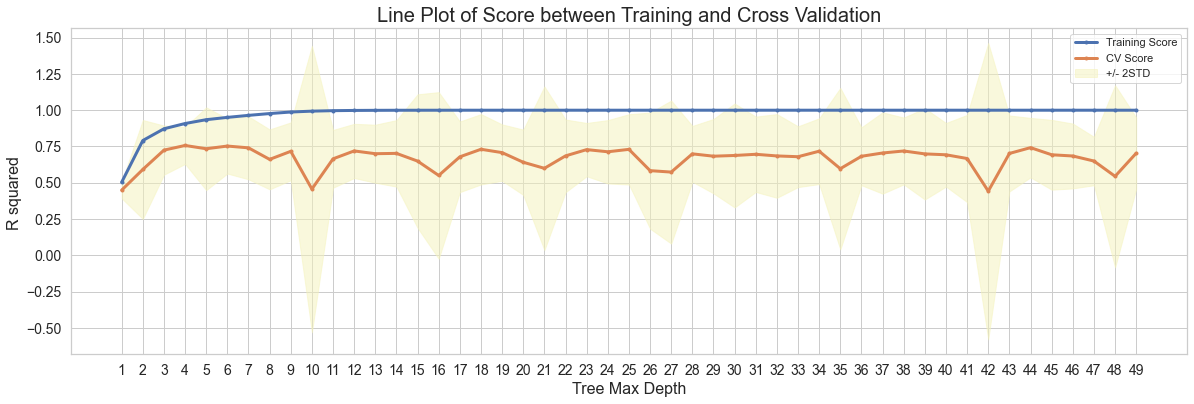

In [84]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(depths, train_scores, '.-', label='Training Score', lw=3)
ax.plot(depths, cvmeans, '.-', label='CV Score', lw=3)
plt.fill_between(depths, cvmeans+2*cvstds, cvmeans-2*cvstds, color='#F5F3BB', alpha=0.5, label="+/- 2STD")

ax.set_xticks(depths)
ax.set_xlabel("Tree Max Depth", fontsize=16)
ax.set_ylabel("R squared ", fontsize=16)

ax.tick_params(labelsize=14)
ax.legend()

ax.set_title("Line Plot of Score between Training and Cross Validation", fontsize=20)
plt.show()


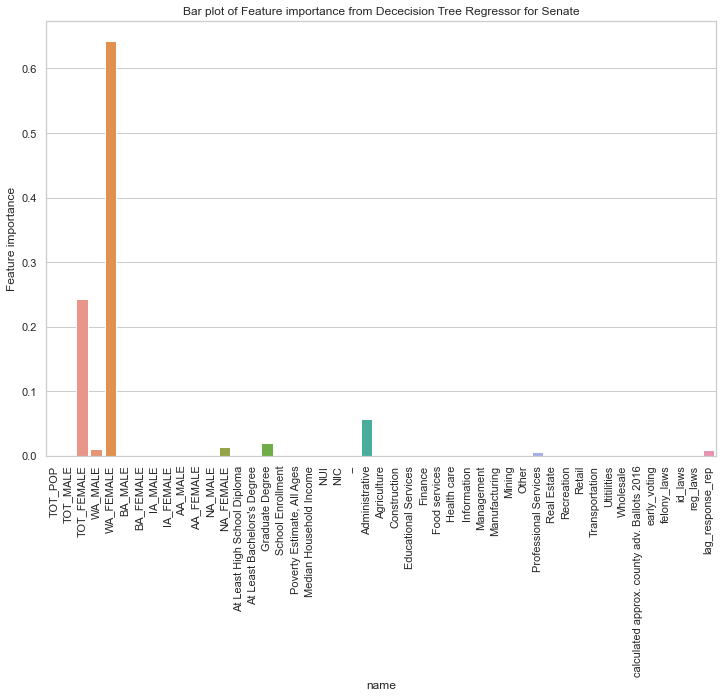

In [93]:
###Feature importance
dtree = DecisionTreeRegressor(max_depth=4).fit(X_train_std, y_train)
feature=pd.DataFrame(dtree.feature_importances_)
feature=feature.copy()
feature[['name']]=house_training_select.columns

feature

plt.figure(figsize=(12,8))

ax = sns.barplot(x="name", y=0, data=feature)
ax.set_ylabel("Feature importance")
ax.set_title("Bar plot of Feature importance from Dececision Tree Regressor for Senate")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [89]:
####Ridge regression approach 
ridgecv=RidgeCV(cv=3)
ridgecv.fit(X_train_std,y_train)
score=ridgecv.score(X_train_std,y_train)
cv_bes=ridgecv.best_score_
print(f"Ridge regression R squared for training set all parameters is {score:.4f}")
print(f"Ridge regression R squared for validation all parameters is {cv_bes:.4f}")

Ridge regression R squared for training set all parameters is 0.9359
Ridge regression R squared for validation all parameters is 0.8624


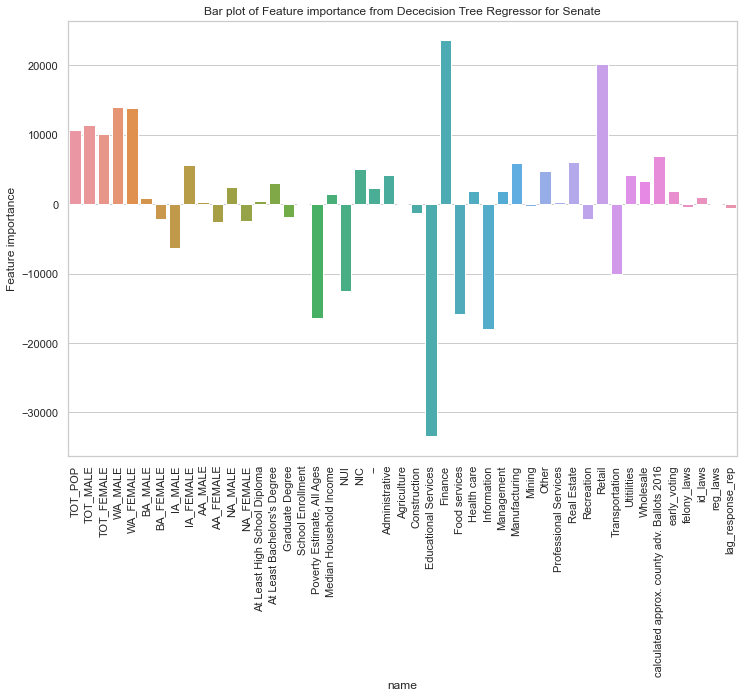

In [98]:
ridge_feature=pd.DataFrame(ridgecv.coef_)
ridge_feature=ridge_feature.copy()
ridge_feature[['name']]=house_training_select.columns

plt.figure(figsize=(12,8))

ax = sns.barplot(x="name", y=0, data=ridge_feature)
ax.set_ylabel("Feature importance")
ax.set_title("Bar plot of Feature importance from Dececision Tree Regressor for Senate")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()